
# 03. Simulate Gamma Rhythms

This example demonstrates how to simulate gamma rhythms via the well
established pyramidal-interneuron-gamma mechanisms [1],
as detailed in the [HNN GUI gamma tutorial](),
using HNN-Core.

We recommend you first review the GUI tutorial.
The workflow below recreates weak gamma rhythms similar to Figures 4 and 5
of the GUI tutorial, and strong gamma rhythms similar to Figure 12 and 13
in the GUI tutorial.


In [2]:
# Authors: Mainak Jas <mjas@mgh.harvard.edu>
#          Sam Neymotin <samnemo@gmail.com>
#          Christopher Bailey <bailey.cj@gmail.com>

# sphinx_gallery_thumbnail_number = 2

import os.path as op

Let us import hnn_core



In [ ]:
import hnn_core
import matplotlib.pyplot as plt
from hnn_core import simulate_dipole, read_params, jones_2009_model

hnn_core_root = op.dirname(hnn_core.__file__)

--No graphics will be displayed.


Read the parameter file and print the between-cell connectivity parameters.
Note that these are different compared with the 'default' parameter set used in, e.g., `sphx_glr_auto_examples_workflows_plot_simulate_alpha.py`.



In [4]:
params_fname = op.join(
    hnn_core_root,
    'param',
    'gamma_L5weak_L2weak.json'
)
params = read_params(params_fname)
print(params['gbar_L*'])

{
    "gbar_L2Basket_L2Basket": 0.01,
    "gbar_L2Basket_L2Pyr_gabaa": 0.007,
    "gbar_L2Basket_L2Pyr_gabab": 0.0,
    "gbar_L2Basket_L5Pyr": 0.0,
    "gbar_L2Pyr_L2Basket": 0.0012,
    "gbar_L2Pyr_L2Pyr_ampa": 0.0,
    "gbar_L2Pyr_L2Pyr_nmda": 0.0,
    "gbar_L2Pyr_L5Basket": 0.0,
    "gbar_L2Pyr_L5Pyr": 0.0,
    "gbar_L5Basket_L5Basket": 0.0075,
    "gbar_L5Basket_L5Pyr_gabaa": 0.08,
    "gbar_L5Basket_L5Pyr_gabab": 0.0,
    "gbar_L5Pyr_L5Basket": 0.00091,
    "gbar_L5Pyr_L5Pyr_ampa": 0.0,
    "gbar_L5Pyr_L5Pyr_nmda": 0.0
}


We'll next add a tonic Poisson-distributed excitation to pyramidal cells

In [5]:
net = jones_2009_model(params)

weights_ampa = {
    'L2_pyramidal': 0.0008,
    'L5_pyramidal': 0.0075,
}
synaptic_delays = {
    'L2_pyramidal': 0.1,
    'L5_pyramidal': 1.0,
}
rate_constant = {
    'L2_pyramidal': 140.0,
    'L5_pyramidal': 40.0,
}
net.add_poisson_drive(
    'poisson',
    rate_constant=rate_constant,
    weights_ampa=weights_ampa,
    location='proximal',
    synaptic_delays=synaptic_delays,
    event_seed=1349
)

And then we'll simulate the dipole moment in a single trial. (Note: the default value used by `simulate_dipole` is n_trials=params["N_trials"].)

In [6]:
dpls = simulate_dipole(
    net,
    tstop=250.,
)
scaling_factor = 30000
dpls = [dpl.scale(scaling_factor) for dpl in dpls]  # scale in place

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /opt/homebrew/Caskroom/miniconda/base/envs/website-redesign/lib/python3.12/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...


Take a look at how different cell types respond to the exogenous drive. Note
the periodic firing pattern of all cell types. While the basket cells fire
relatively synchronously, the pyramidal cell populations display a more
varied pattern, in which only a fraction of cells reach firing threshold.



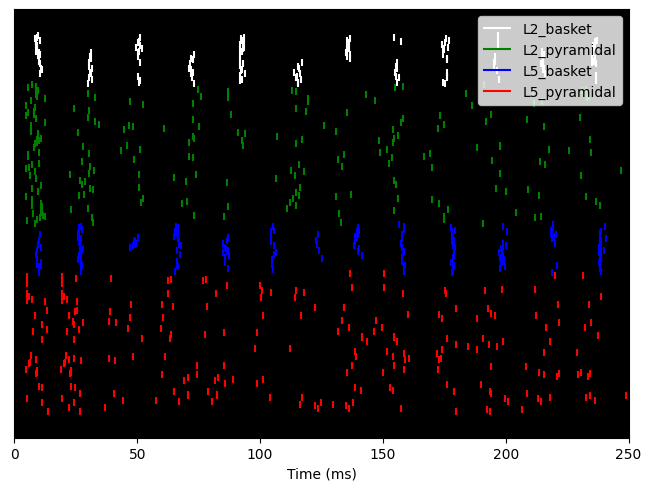

In [7]:
_ = net.cell_response.plot_spikes_raster()

plt.show()

To confirm that the periodicity observed in the firing patterns correspond to
a population oscillation in the gamma-range, we can plot the time-frequency
representation together with the signal. Note that the network requires some
time to reach steady state. Hence, we omit the first 50 ms in our analysis.



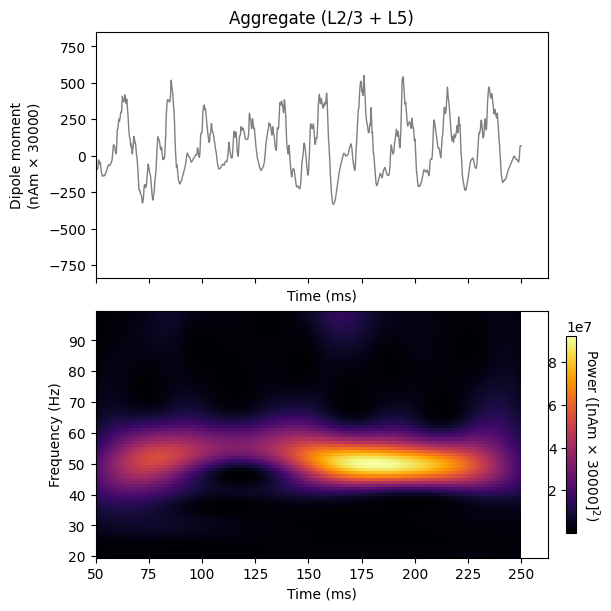

In [8]:
tmin = 50
trial_idx = 0  # pick first trial

# plot dipole time course and time-frequency
# representation in same figure
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=(6, 6),
    constrained_layout=True,
)

dpls[trial_idx].plot(
    tmin=tmin,
    ax=axes[0],
    show=False,
)

# Create an fixed-step tiling of frequencies 
# from 20 to 100 Hz in steps of 1 Hz
freqs = np.arange(20., 100., 1.)
dpls[trial_idx].plot_tfr_morlet(
    freqs,
    n_cycles=7,
    tmin=tmin,
    ax=axes[1],
    show=False,
)

plt.show()

Now, let us try to re-run the simulation with a tonic bias
applied to the L5 Pyramidal cells. Notice that the oscillation waveform is
more regular, with less noise due to the fact that the tonic depolarization
dominates over the influence of the Poisson drive. By default, a tonic bias
is applied to the entire duration of the simulation.



In [9]:
net.add_tonic_bias(
    cell_type='L5_pyramidal',
    amplitude=6.,
)
dpls = simulate_dipole(
    net,
    tstop=250.,
    n_trials=1,
)
dpls = [dpl.scale(scaling_factor) for dpl in dpls]  # scale in place

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...


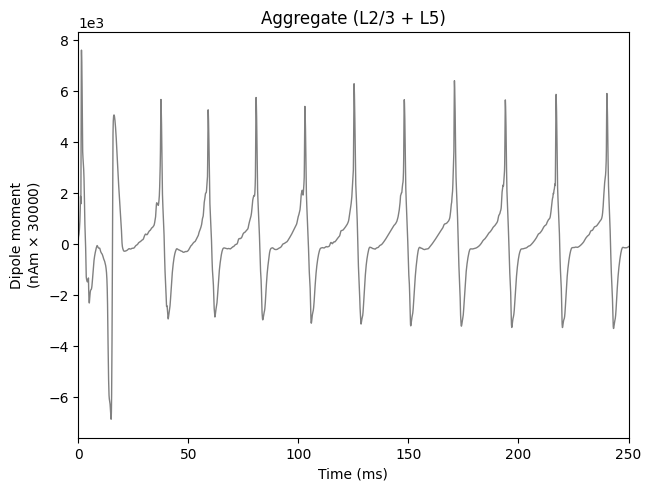

In [10]:
_ = dpls[trial_idx].plot()

plt.show()

Notice that the Layer 5 pyramidal neurons now fire nearly synchronously,
leading to a synchronous activation of the inhibitory basket neurons,
resulting in a low-latency IPSP back onto the pyramidal cells. The duration
of the IPSP is ~20 ms, after which the combined effect of the tonic bias and
Poisson drive is to bring the pyramidal cells back to firing threshold,
creating a ~50 Hz PING rhythm. This type of synchronous rhythm is sometimes
referred to as “strong” PING.



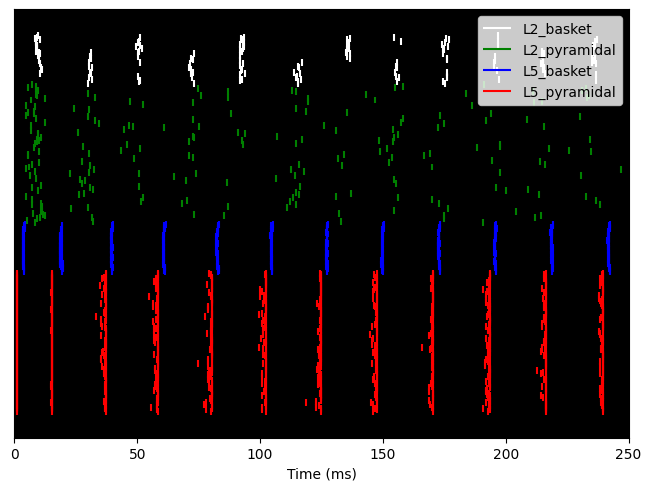

In [11]:
_ = net.cell_response.plot_spikes_raster()

plt.show()

Although the simulated dipole signal demonstrates clear periodicity, its
frequency is lower compared with the "weak" PING simulation above.



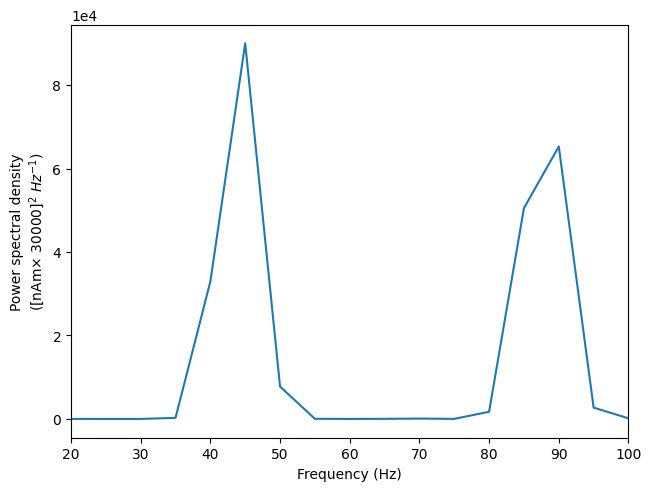

In [12]:
from hnn_core.viz import plot_psd
_ = plot_psd(
    dpls[trial_idx],
    fmin=20.,
    fmax=100.,
    tmin=tmin,
)

plt.show()

Finally, we demonstrate the mechanistic link between PING and the GABAA decay
time constant (`tau2`). Using the same network/drive configuration as before,
we decrease `tau2` from 5 to 2 ms.



In [13]:
net.cell_types['L5_pyramidal'].synapses['gabaa']['tau2'] = 2

dpls = simulate_dipole(
    net,
    tstop=250.,
    n_trials=1,
)
dpls = [dpl.scale(scaling_factor) for dpl in dpls]  # scale in place

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...


This change will shorten the effective refactory period between L5 pyramidal cell spikes and increase the PING
frequency from ~50 to ~65 Hz, as seen in the plots below

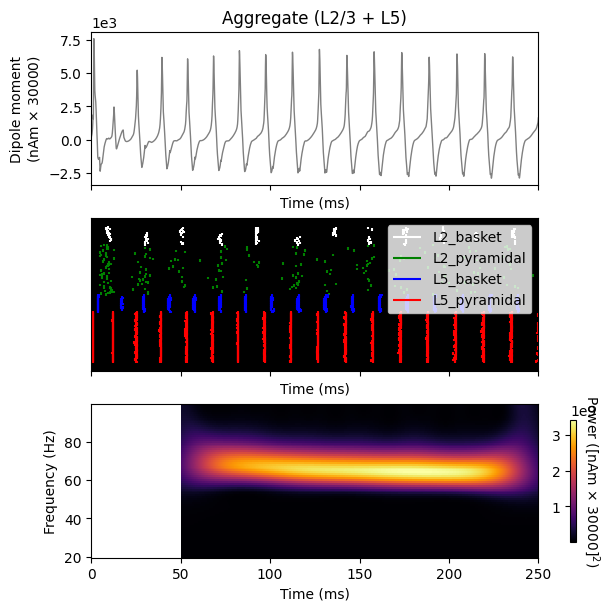

In [14]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    sharex=True,
    figsize=(6, 6),
    constrained_layout=True,
)

dpls[trial_idx].plot(
    ax=axes[0],
    show=False,
)

net.cell_response.plot_spikes_raster(
    ax=axes[1],
    show=False,
)

dpls[trial_idx].plot_tfr_morlet(
    freqs,
    n_cycles=7,
    tmin=tmin,
    ax=axes[2],
    show=False,
)

plt.show()

## References
[1] Lee, S. & Jones, S. R. Distinguishing mechanisms of gamma frequency
       oscillations in human current source signals using a computational
       model of a laminar neocortical network. Frontiers in human
       neuroscience (2013)

